# Table of Contents
 <p><div class="lev1 toc-item"><a href="#reading-and-preparing-data" data-toc-modified-id="reading-and-preparing-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>reading and preparing data</a></div>

# reading and preparing data

In [8]:
#library(ggbiplot)
library(plyr)
library(tidyverse, quiet=T)
library(traj)
library(caret, quiet=T)

In [2]:
dat0 <- read.csv("../training_ultrasound.csv")

# Use Hadlok equation to estimate fetal weight from the 4 key ultrasound measurements
dat.raw = dat0 %>%
    mutate(
        LOG10.FWT.GM = 1.3596 + 0.0064*HCIRCM + 0.0424*ABCIRCM + 0.174*FEMURCM + 0.00061*BPDCM*ABCIRCM - 0.00386*ABCIRCM*FEMURCM,
        WTKG.estimate = ifelse(AGEDAYS<1 ,(10^LOG10.FWT.GM)/1000 ,WTKG) ,
        Study = paste('Study', STUDYID)
        )
dat.raw %>% glimpse
# clean data, remove samples with only one observation and after-birth
dat = dat.raw %>% group_by(SUBJID) %>%
    mutate(tot.measurements = n()) %>%
    filter(tot.measurements >1) %>%
    filter(AGEDAYS<0)


dat.train.raw = dat %>% ungroup %>%
    select(GAGEDAYS, SUBJID, ABCIRCM, HCIRCM, BPDCM, FEMURCM, BWT_40) %>%
    filter(complete.cases(.)) %>% group_by(SUBJID) %>%
    mutate(measurementId = row_number(), tot_measurements=n()) %>%
#    filter(measurementId < 7) %>%
#    filter(tot_measurements >1) %>% 
    ungroup
#     filter(GAGEDAYS > 150, GAGEDAYS <210)

dat.train = dat.train.raw

dat.train.raw %>% head

Observations: 17,370
Variables: 37
$ STUDYID       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ SUBJID        <int> 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003, 1003,...
$ SEXN          <int> 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ SEX           <fctr> Female, Female, Female, Male, Male, Male, Male, Male...
$ GAGEBRTH      <int> 276, 276, 276, 280, 280, 280, 280, 280, 280, 280, 280...
$ BIRTHWT       <int> 3540, 3540, 3540, 3100, 3100, 3100, 3100, 3100, 3100,...
$ BIRTHLEN      <dbl> 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3, 50.3,...
$ BIRTHHC       <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...
$ DELIVERY      <fctr> Category 2.0, Category 2.0, Category 2.0, Category 2...
$ PARITY        <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ GRAVIDA       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ GAGEDAYS      <int> 255, 277, 669, 223, 224, 263, 266, 281, 321, 463, 645...
$ AGEDAYS       <

GAGEDAYS,SUBJID,ABCIRCM,HCIRCM,BPDCM,FEMURCM,BWT_40,measurementId,tot_measurements
255,1002,32.5,33.4,9.1,7.3,3.614882,1,1
223,1003,25.6,29.2,8.2,6.3,3.100000,1,4
224,1003,25.6,29.2,8.2,6.3,3.100000,2,4
263,1003,30.2,31.0,9.1,7.2,3.100000,3,4
266,1003,30.2,31.0,9.1,7.2,3.100000,4,4
169,1005,18.7,21.9,5.9,4.1,2.988224,1,3


# simple regression using GAGEDAYS as covariate

In [6]:
dat.gbm = train(BWT_40~., 
                data=dat.train.raw %>%select(-measurementId, tot_measurements), 
                method="glmnet", 
                preProcess=c("center", "scale", "knnImpute"), 
                verbose=F)


gbm variable importance

                 Overall
ABCIRCM          100.000
GAGEDAYS          68.779
FEMURCM            7.482
SUBJID             6.727
HCIRCM             5.924
BPDCM              5.878
tot_measurements   0.000

Stochastic Gradient Boosting 

7928 samples
   7 predictors

Pre-processing: centered (7), scaled (7), nearest neighbor imputation (7) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 7928, 7928, 7928, 7928, 7928, 7928, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE       Rsquared 
  1                   50      0.3455480  0.1121584
  1                  100      0.3392683  0.1492769
  1                  150      0.3346184  0.1733923
  2                   50      0.3315173  0.1913168
  2                  100      0.3208605  0.2374312
  2                  150      0.3148105  0.2608505
  3                   50      0.3236107  0.2288208
  3                  100      0.3129685  0.2702914
  3                  150      0.3071877  0.2920962

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
RMSE was used to select the optimal model using  the smallest value.
T

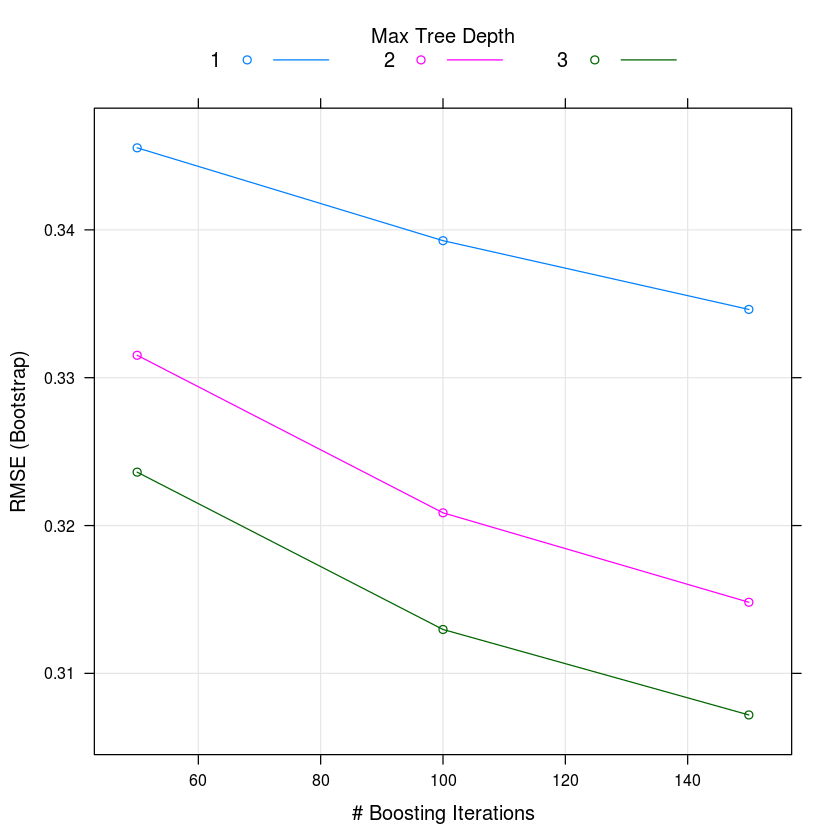

In [7]:
varImp(dat.gbm)
dat.gbm
plot(dat.gbm)

In [5]:
dat.gbm = train(BWT_40~.+GAGEDAYS, data=dat.train.raw, method="gbm", preProcess=c("center", "scale", "knnImpute"), verbose=F)
